In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import koreanize_matplotlib
koreanize_matplotlib.koreanize()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 로드
train = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\train.csv')
test = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\test.csv')
submission = pd.read_csv(r'E:\2026_1\캐글 공모전\playground-series-s6e1\sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nColumns: {train.columns.tolist()}")

Train shape: (630000, 13)
Test shape: (270000, 12)

Columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']


## 1. 데이터 생성 로직 역추적

Kaggle Playground Series 데이터는 일반적으로 CTGAN이나 선형 공식 기반으로 생성됨.
exam_score가 어떤 공식으로 만들어졌는지 역추적해보자.

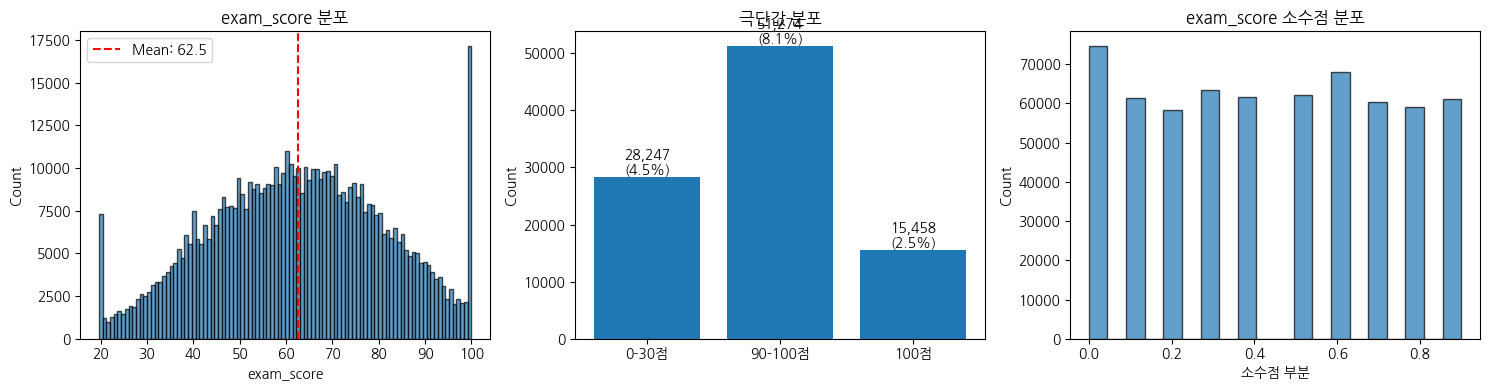

전체 데이터: 630,000
100점: 15,458 (2.45%)
정수 점수 비율: 11.85%


In [3]:
# exam_score 기본 분포 확인
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 히스토그램
axes[0].hist(train['exam_score'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('exam_score')
axes[0].set_ylabel('Count')
axes[0].set_title('exam_score 분포')
axes[0].axvline(train['exam_score'].mean(), color='r', linestyle='--', label=f"Mean: {train['exam_score'].mean():.1f}")
axes[0].legend()

# 0-30점과 90-100점 비율
low_scores = (train['exam_score'] <= 30).sum()
high_scores = (train['exam_score'] >= 90).sum()
extreme_100 = (train['exam_score'] == 100).sum()

axes[1].bar(['0-30점', '90-100점', '100점'], [low_scores, high_scores, extreme_100])
axes[1].set_ylabel('Count')
axes[1].set_title('극단값 분포')
for i, v in enumerate([low_scores, high_scores, extreme_100]):
    axes[1].text(i, v, f'{v:,}\n({v/len(train)*100:.1f}%)', ha='center', va='bottom')

# 소수점 패턴 확인
decimal_part = train['exam_score'] % 1
axes[2].hist(decimal_part, bins=20, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('소수점 부분')
axes[2].set_ylabel('Count')
axes[2].set_title('exam_score 소수점 분포')

plt.tight_layout()
plt.show()

print(f"전체 데이터: {len(train):,}")
print(f"100점: {extreme_100:,} ({extreme_100/len(train)*100:.2f}%)")
print(f"정수 점수 비율: {(decimal_part == 0).sum() / len(train) * 100:.2f}%")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8684\1059764877.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  study_means = train.groupby(study_bins)['exam_score'].mean()


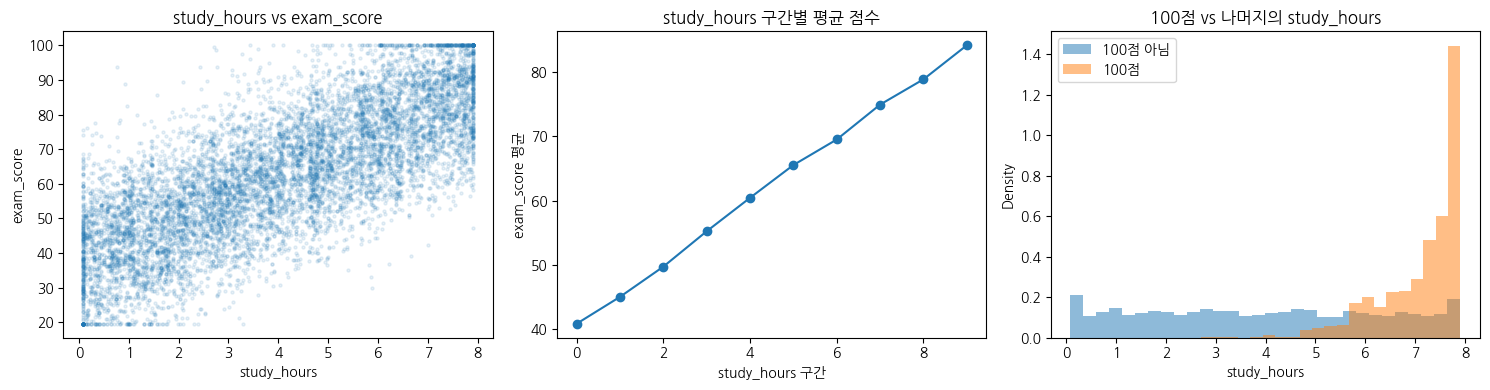

100점의 study_hours 평균: 7.14
나머지의 study_hours 평균: 3.92


In [4]:
# study_hours와 exam_score의 관계를 상세히 분석
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# study_hours vs exam_score 산점도
sample = train.sample(10000, random_state=42)
axes[0].scatter(sample['study_hours'], sample['exam_score'], alpha=0.1, s=5)
axes[0].set_xlabel('study_hours')
axes[0].set_ylabel('exam_score')
axes[0].set_title('study_hours vs exam_score')

# study_hours 구간별 exam_score 평균
study_bins = pd.cut(train['study_hours'], bins=10)
study_means = train.groupby(study_bins)['exam_score'].mean()
axes[1].plot(range(len(study_means)), study_means.values, 'o-')
axes[1].set_xlabel('study_hours 구간')
axes[1].set_ylabel('exam_score 평균')
axes[1].set_title('study_hours 구간별 평균 점수')

# 100점인 샘플의 study_hours 분포
score_100 = train[train['exam_score'] == 100]
score_not100 = train[train['exam_score'] != 100]
axes[2].hist(score_not100['study_hours'], bins=30, alpha=0.5, label='100점 아님', density=True)
axes[2].hist(score_100['study_hours'], bins=30, alpha=0.5, label='100점', density=True)
axes[2].set_xlabel('study_hours')
axes[2].set_ylabel('Density')
axes[2].set_title('100점 vs 나머지의 study_hours')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"100점의 study_hours 평균: {score_100['study_hours'].mean():.2f}")
print(f"나머지의 study_hours 평균: {score_not100['study_hours'].mean():.2f}")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8684\2183416677.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rate_100 = train.groupby(col).apply(lambda x: (x['exam_score'] == 100).mean() * 100)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_8684\2183416677.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rate_100 = train.groupby(col).apply(lambda x: (x['exam_score'] == 100).mean() * 100)


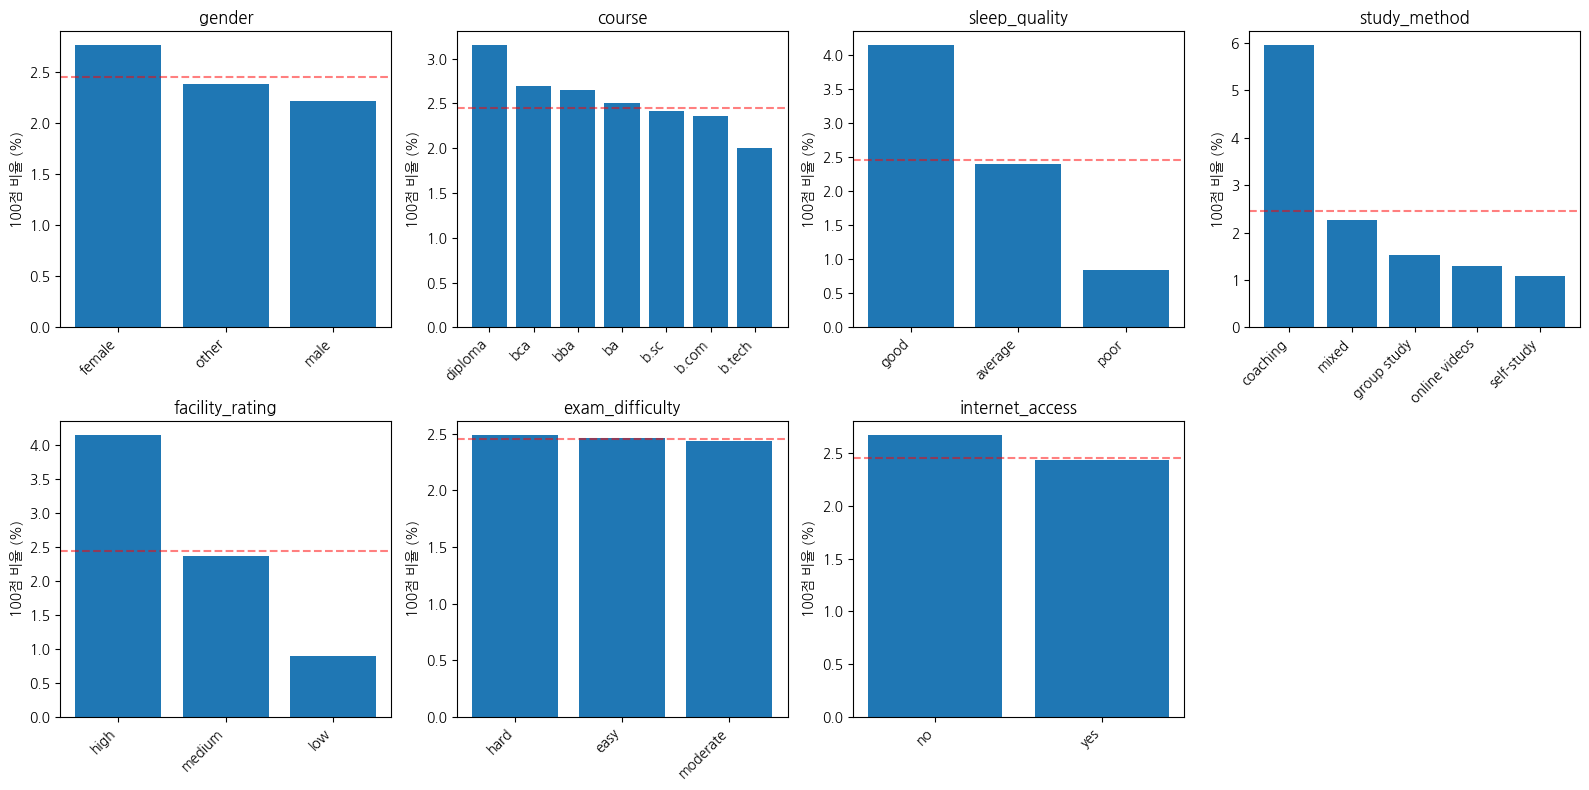

In [5]:
# 100점인 샘플의 특성 분석
score_100 = train[train['exam_score'] == 100]
score_others = train[train['exam_score'] != 100]

# 각 범주형 변수별 100점 비율
cat_cols = ['gender', 'course', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'internet_access']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    rate_100 = train.groupby(col).apply(lambda x: (x['exam_score'] == 100).mean() * 100)
    rate_100 = rate_100.sort_values(ascending=False)
    axes[i].bar(range(len(rate_100)), rate_100.values)
    axes[i].set_xticks(range(len(rate_100)))
    axes[i].set_xticklabels(rate_100.index, rotation=45, ha='right')
    axes[i].set_ylabel('100점 비율 (%)')
    axes[i].set_title(col)
    axes[i].axhline(y=2.45, color='r', linestyle='--', alpha=0.5)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

In [6]:
# 100점이 아닌 샘플만으로 선형 회귀 적합해서 데이터 생성 공식 역추적
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder

# 100점이 아닌 샘플만 사용 (clipping 효과 제거)
train_no100 = train[train['exam_score'] < 100].copy()

# 범주형 변수 인코딩
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train_no100[col + '_enc'] = le.fit_transform(train_no100[col])
    le_dict[col] = le

# 수치형 변수만으로 먼저 선형 회귀
numeric_cols = ['study_hours', 'class_attendance', 'sleep_hours', 'age']
X_numeric = train_no100[numeric_cols]
y_target = train_no100['exam_score']

lr = LinearRegression()
lr.fit(X_numeric, y_target)

print("수치형 변수만으로 선형 회귀:")
print(f"R2 Score: {lr.score(X_numeric, y_target):.4f}")
print(f"\n계수:")
for col, coef in zip(numeric_cols, lr.coef_):
    print(f"  {col}: {coef:.4f}")
print(f"  절편: {lr.intercept_:.4f}")

수치형 변수만으로 선형 회귀:
R2 Score: 0.6680

계수:
  study_hours: 5.6815
  class_attendance: 0.3071
  sleep_hours: 1.3289
  age: 0.0108
  절편: 7.6746


In [7]:
# 범주형 변수별 평균 점수 효과 분석
print("범주형 변수별 평균 점수 (100점 제외):")
print("="*50)

for col in cat_cols:
    means = train_no100.groupby(col)['exam_score'].mean().sort_values(ascending=False)
    overall_mean = train_no100['exam_score'].mean()
    print(f"\n{col}:")
    for cat, mean in means.items():
        effect = mean - overall_mean
        print(f"  {cat}: {mean:.2f} (차이: {effect:+.2f})")

범주형 변수별 평균 점수 (100점 제외):

gender:
  other: 61.87 (차이: +0.31)
  female: 61.50 (차이: -0.06)
  male: 61.32 (차이: -0.25)

course:
  bba: 62.23 (차이: +0.67)
  b.tech: 61.75 (차이: +0.19)
  b.com: 61.63 (차이: +0.07)
  bca: 61.55 (차이: -0.01)
  b.sc: 61.36 (차이: -0.20)
  diploma: 61.18 (차이: -0.38)
  ba: 60.91 (차이: -0.65)

sleep_quality:
  good: 66.50 (차이: +4.94)
  average: 61.75 (차이: +0.18)
  poor: 56.63 (차이: -4.93)

study_method:
  coaching: 67.32 (차이: +5.76)
  mixed: 64.30 (차이: +2.73)
  group study: 59.92 (차이: -1.65)
  online videos: 59.20 (차이: -2.36)
  self-study: 57.24 (차이: -4.32)

facility_rating:
  high: 65.26 (차이: +3.70)
  medium: 62.13 (차이: +0.57)
  low: 57.57 (차이: -3.99)

exam_difficulty:
  hard: 61.72 (차이: +0.15)
  moderate: 61.67 (차이: +0.11)
  easy: 61.26 (차이: -0.30)

internet_access:
  yes: 61.57 (차이: +0.01)
  no: 61.45 (차이: -0.12)


## 2. 전략 수립: 이진 분류 기반 극단값 처리

관찰 결과:
1. 100점이 2.45%로 많고, 특정 패턴(높은 study_hours + coaching + good sleep_quality 등)에서 발생
2. 데이터는 선형 공식 기반 + 노이즈 + clipping(0-100)으로 생성된 것으로 추정
3. 100점은 "실제 점수 >= 100"인 경우 clipping된 결과

전략:
- Step 1: 100점 여부를 이진 분류로 예측
- Step 2: 100점이 아닌 샘플만으로 회귀 모델 학습
- Step 3: 분류 확률과 회귀 예측을 결합

In [8]:
# 100점 예측을 위한 이진 분류 레이블 생성
train['is_100'] = (train['exam_score'] == 100).astype(int)

print(f"100점 비율: {train['is_100'].mean()*100:.2f}%")
print(f"100점 개수: {train['is_100'].sum():,}")

100점 비율: 2.45%
100점 개수: 15,458


In [9]:
# 피처 준비: 순서형 변수 인코딩
def encode_ordinal(df):
    df = df.copy()
    sleep_map = {'poor': 1, 'average': 2, 'good': 3}
    facility_map = {'low': 1, 'medium': 2, 'high': 3}
    difficulty_map = {'easy': 1, 'moderate': 2, 'hard': 3}
    
    df['sleep_quality_num'] = df['sleep_quality'].map(sleep_map)
    df['facility_num'] = df['facility_rating'].map(facility_map)
    df['difficulty_num'] = df['exam_difficulty'].map(difficulty_map)
    
    return df

train = encode_ordinal(train)
test = encode_ordinal(test)

print("순서형 변수 인코딩 완료")

순서형 변수 인코딩 완료


In [10]:
# 명목형 변수 라벨 인코딩 및 타겟 인코딩
from sklearn.preprocessing import LabelEncoder

cat_cols = ['gender', 'course', 'study_method', 'internet_access']

# 라벨 인코딩
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col + '_enc'] = le.fit_transform(train[col])
    test[col + '_enc'] = le.transform(test[col])
    label_encoders[col] = le

# 타겟 인코딩 (100점 제외한 평균)
train_no100 = train[train['exam_score'] != 100]
for col in cat_cols + ['sleep_quality', 'facility_rating', 'exam_difficulty']:
    target_mean = train_no100.groupby(col)['exam_score'].mean().to_dict()
    train[col + '_target'] = train[col].map(target_mean)
    test[col + '_target'] = test[col].map(target_mean)

print("명목형 변수 인코딩 완료")

명목형 변수 인코딩 완료


In [11]:
# 핵심 파생변수 생성
def create_features(df):
    df = df.copy()
    
    # 공부 효과 (핵심 변수들의 조합)
    df['study_attendance'] = df['study_hours'] * df['class_attendance'] / 100
    df['study_quality'] = df['study_hours'] * df['sleep_quality_num']
    df['study_facility'] = df['study_hours'] * df['facility_num']
    
    # 복합 점수
    df['total_score'] = (
        df['study_hours'] / 8 * 40 +  # 최대 40점
        df['class_attendance'] / 100 * 20 +  # 최대 20점
        df['sleep_quality_num'] / 3 * 10 +  # 최대 10점
        df['facility_num'] / 3 * 10  # 최대 10점
    )
    
    # 100점 가능성 관련 피처
    df['high_study'] = (df['study_hours'] >= 7).astype(int)
    df['high_attendance'] = (df['class_attendance'] >= 90).astype(int)
    df['good_conditions'] = (
        (df['sleep_quality_num'] == 3) & 
        (df['facility_num'] >= 2)
    ).astype(int)
    
    return df

train = create_features(train)
test = create_features(test)

print("파생변수 생성 완료")
print(f"Train columns: {train.shape[1]}")

파생변수 생성 완료
Train columns: 35


In [12]:
# 피처 컬럼 정의
exclude_cols = ['id', 'exam_score', 'is_100', 'gender', 'course', 'sleep_quality', 
                'study_method', 'facility_rating', 'exam_difficulty', 'internet_access']

feature_cols = [col for col in train.columns if col not in exclude_cols]

print(f"사용할 피처 수: {len(feature_cols)}")
print(f"\n피처 목록: {feature_cols}")

사용할 피처 수: 25

피처 목록: ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality_num', 'facility_num', 'difficulty_num', 'gender_enc', 'course_enc', 'study_method_enc', 'internet_access_enc', 'gender_target', 'course_target', 'study_method_target', 'internet_access_target', 'sleep_quality_target', 'facility_rating_target', 'exam_difficulty_target', 'study_attendance', 'study_quality', 'study_facility', 'total_score', 'high_study', 'high_attendance', 'good_conditions']


## 3. Step 1: 100점 이진 분류 모델

In [13]:
# 100점 분류 모델 (LightGBM)
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

X = train[feature_cols]
y_binary = train['is_100']
X_test_final = test[feature_cols]

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_proba = np.zeros(len(X))
test_proba = np.zeros(len(X_test_final))

print("100점 이진 분류 모델 학습 시작...")

100점 이진 분류 모델 학습 시작...


In [14]:
# LightGBM 분류 모델 K-Fold 학습
lgb_clf_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 8,
    'num_leaves': 50,
    'min_child_samples': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1
}

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y_binary)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y_binary.iloc[train_idx], y_binary.iloc[valid_idx]
    
    clf = lgb.LGBMClassifier(**lgb_clf_params)
    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    
    valid_proba = clf.predict_proba(X_valid)[:, 1]
    oof_proba[valid_idx] = valid_proba
    test_proba += clf.predict_proba(X_test_final)[:, 1] / n_splits
    
    auc = roc_auc_score(y_valid, valid_proba)
    print(f"Fold {fold+1}: AUC = {auc:.4f}")

Fold 1: AUC = 0.9654
Fold 2: AUC = 0.9669
Fold 3: AUC = 0.9656
Fold 4: AUC = 0.9671
Fold 5: AUC = 0.9658


In [15]:
# 분류 모델 성능 평가
overall_auc = roc_auc_score(y_binary, oof_proba)
print(f"Overall AUC: {overall_auc:.4f}")

# 임계값별 성능 확인
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print("\n임계값별 성능:")
for th in thresholds:
    pred = (oof_proba >= th).astype(int)
    prec = precision_score(y_binary, pred)
    rec = recall_score(y_binary, pred)
    f1 = f1_score(y_binary, pred)
    print(f"  Threshold {th}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

Overall AUC: 0.9661

임계값별 성능:
  Threshold 0.3: Precision=0.477, Recall=0.466, F1=0.472
  Threshold 0.4: Precision=0.559, Recall=0.339, F1=0.422
  Threshold 0.5: Precision=0.632, Recall=0.227, F1=0.334
  Threshold 0.6: Precision=0.697, Recall=0.131, F1=0.220
  Threshold 0.7: Precision=0.780, Recall=0.055, F1=0.103


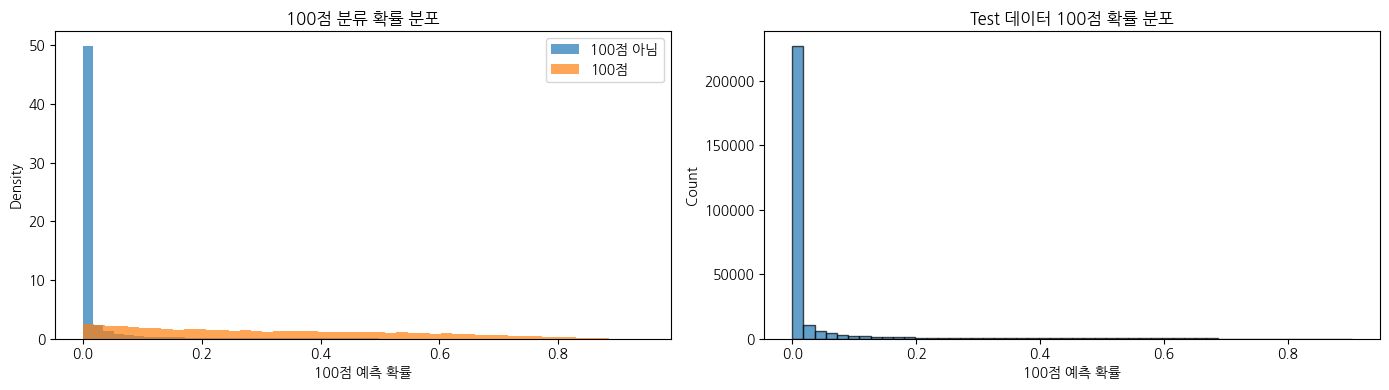

Test에서 100점 예측 비율 (th=0.5): 0.83%


In [16]:
# 100점 분류 확률 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 실제 100점 vs 나머지의 확률 분포
axes[0].hist(oof_proba[y_binary == 0], bins=50, alpha=0.7, label='100점 아님', density=True)
axes[0].hist(oof_proba[y_binary == 1], bins=50, alpha=0.7, label='100점', density=True)
axes[0].set_xlabel('100점 예측 확률')
axes[0].set_ylabel('Density')
axes[0].set_title('100점 분류 확률 분포')
axes[0].legend()

# Test 데이터의 100점 예측 확률 분포
axes[1].hist(test_proba, bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('100점 예측 확률')
axes[1].set_ylabel('Count')
axes[1].set_title('Test 데이터 100점 확률 분포')

plt.tight_layout()
plt.show()

print(f"Test에서 100점 예측 비율 (th=0.5): {(test_proba >= 0.5).mean()*100:.2f}%")

## 4. Step 2: 회귀 모델 (100점 제외하고 학습)

In [17]:
# 회귀 모델용 데이터 (100점 제외)
train_reg = train[train['exam_score'] != 100].copy()
X_reg = train_reg[feature_cols]
y_reg = train_reg['exam_score']

print(f"회귀 학습 데이터: {len(X_reg):,}개 (100점 제외)")
print(f"y_reg 범위: {y_reg.min():.1f} ~ {y_reg.max():.1f}")

회귀 학습 데이터: 614,542개 (100점 제외)
y_reg 범위: 19.6 ~ 99.9


In [18]:
# LightGBM 회귀 모델 K-Fold 학습
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)

oof_reg_preds = np.zeros(len(X_reg))
test_reg_preds = np.zeros(len(X_test_final))

lgb_reg_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 10,
    'num_leaves': 64,
    'min_child_samples': 50,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1
}

print("회귀 모델 학습 시작...")
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reg)):
    X_train, X_valid = X_reg.iloc[train_idx], X_reg.iloc[valid_idx]
    y_train, y_valid = y_reg.iloc[train_idx], y_reg.iloc[valid_idx]
    
    reg = lgb.LGBMRegressor(**lgb_reg_params)
    reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    
    valid_pred = reg.predict(X_valid)
    oof_reg_preds[valid_idx] = valid_pred
    test_reg_preds += reg.predict(X_test_final) / 5
    
    rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    print(f"Fold {fold+1}: RMSE = {rmse:.4f}")

회귀 모델 학습 시작...
Fold 1: RMSE = 8.6940
Fold 2: RMSE = 8.6482
Fold 3: RMSE = 8.6659
Fold 4: RMSE = 8.6839
Fold 5: RMSE = 8.6810


Overall RMSE (100점 제외): 8.6746


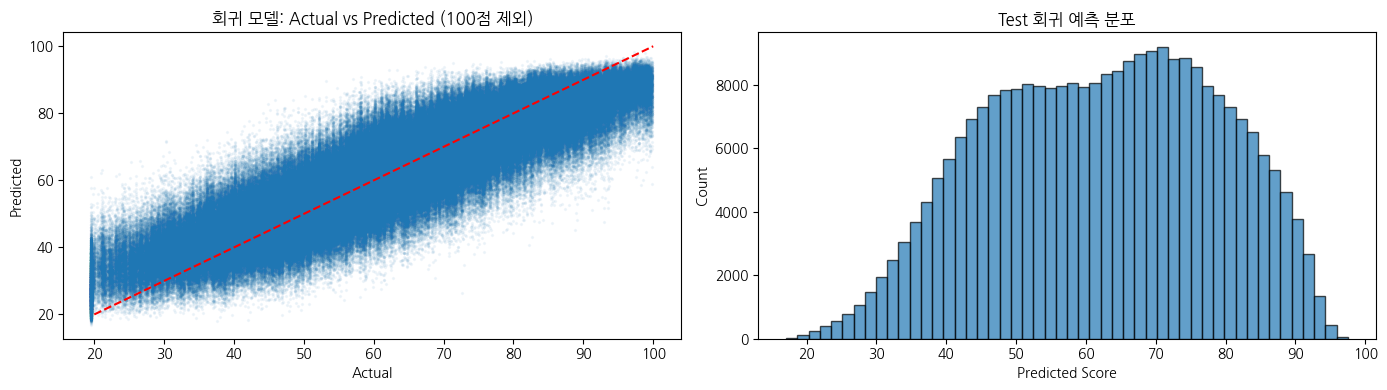

In [19]:
# 회귀 모델 성능 확인
cv_rmse_reg = np.sqrt(mean_squared_error(y_reg, oof_reg_preds))
print(f"Overall RMSE (100점 제외): {cv_rmse_reg:.4f}")

# 회귀 예측 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].scatter(y_reg.values, oof_reg_preds, alpha=0.05, s=2)
axes[0].plot([20, 100], [20, 100], 'r--')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('회귀 모델: Actual vs Predicted (100점 제외)')

axes[1].hist(test_reg_preds, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Predicted Score')
axes[1].set_ylabel('Count')
axes[1].set_title('Test 회귀 예측 분포')

plt.tight_layout()
plt.show()

## 5. Step 3: 분류 + 회귀 결합

100점 확률을 활용해서 예측값을 조정하는 여러 전략 비교:
1. 단순 회귀만 사용
2. 임계값 기반 100점 대체
3. 확률 가중 블렌딩

In [20]:
# 전체 train에 대해 회귀 예측도 수행 (CV 성능 비교용)
X_all = train[feature_cols]
y_all = train['exam_score']

oof_reg_all = np.zeros(len(X_all))
test_reg_all = np.zeros(len(X_test_final))

print("전체 데이터로 회귀 모델 재학습...")
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_all)):
    X_train, X_valid = X_all.iloc[train_idx], X_all.iloc[valid_idx]
    y_train, y_valid = y_all.iloc[train_idx], y_all.iloc[valid_idx]
    
    reg = lgb.LGBMRegressor(**lgb_reg_params)
    reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    
    oof_reg_all[valid_idx] = reg.predict(X_valid)
    test_reg_all += reg.predict(X_test_final) / 5
    
    rmse = np.sqrt(mean_squared_error(y_valid, reg.predict(X_valid)))
    print(f"Fold {fold+1}: RMSE = {rmse:.4f}")

전체 데이터로 회귀 모델 재학습...
Fold 1: RMSE = 8.7459
Fold 2: RMSE = 8.7518
Fold 3: RMSE = 8.7423
Fold 4: RMSE = 8.7607
Fold 5: RMSE = 8.7733


In [21]:
# 다양한 결합 전략 비교 (Train OOF 기준)

def evaluate_strategy(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name}: RMSE = {rmse:.4f}")
    return rmse

print("전략별 CV RMSE 비교:")
print("="*50)

# 전략 1: 단순 회귀만
strategy1 = oof_reg_all.copy()
rmse1 = evaluate_strategy(y_all, strategy1, "1. 단순 회귀")

# 전략 2: 회귀 + 높은 확률이면 100점 대체
strategy2 = oof_reg_all.copy()
strategy2[oof_proba >= 0.5] = 100
rmse2 = evaluate_strategy(y_all, strategy2, "2. 임계값 0.5 100점 대체")

# 전략 3: 확률 가중 블렌딩
strategy3 = oof_reg_all * (1 - oof_proba) + 100 * oof_proba
rmse3 = evaluate_strategy(y_all, strategy3, "3. 확률 가중 블렌딩")

# 전략 4: clipping (0-100 범위)
strategy4 = np.clip(oof_reg_all, 0, 100)
rmse4 = evaluate_strategy(y_all, strategy4, "4. 단순 회귀 + clipping")

전략별 CV RMSE 비교:
1. 단순 회귀: RMSE = 8.7548
2. 임계값 0.5 100점 대체: RMSE = 8.7595
3. 확률 가중 블렌딩: RMSE = 8.7705
4. 단순 회귀 + clipping: RMSE = 8.7548


In [22]:
# 100점 예측에 더 집중하는 전략 시도
# 높은 점수 구간에서 더 정확한 예측을 위해 세분화

# 90점 이상에서의 오차 분석
high_mask = y_all >= 90
residuals_high = y_all[high_mask] - oof_reg_all[high_mask]

print("90점 이상 구간 분석:")
print(f"  샘플 수: {high_mask.sum():,}")
print(f"  잔차 평균: {residuals_high.mean():.3f}")
print(f"  잔차 표준편차: {residuals_high.std():.3f}")
print(f"  과소예측 비율: {(residuals_high > 0).mean()*100:.1f}%")

# 100점에 대한 분석
mask_100 = y_all == 100
pred_for_100 = oof_reg_all[mask_100]
print(f"\n100점 샘플 예측 분석:")
print(f"  예측 평균: {pred_for_100.mean():.2f}")
print(f"  예측 최소: {pred_for_100.min():.2f}")
print(f"  예측 최대: {pred_for_100.max():.2f}")

90점 이상 구간 분석:
  샘플 수: 51,274
  잔차 평균: 8.246
  잔차 표준편차: 6.263
  과소예측 비율: 93.0%

100점 샘플 예측 분석:
  예측 평균: 91.01
  예측 최소: 52.80
  예측 최대: 101.75


In [23]:
# 고득점(90+) 구간 부스팅 전략
# 회귀 예측값이 높을수록 100점 확률을 더 반영

def blend_with_boost(reg_pred, clf_proba, threshold=85, scale=1.5):
    """고득점 구간에서 100점 확률을 더 강하게 반영"""
    result = reg_pred.copy()
    
    # 회귀 예측이 threshold 이상인 경우, 100점 확률을 더 강하게 반영
    high_mask = reg_pred >= threshold
    
    # boost_factor: 회귀 예측이 높을수록 1에 가까움
    boost_factor = np.clip((reg_pred - threshold) / (100 - threshold), 0, 1)
    
    # 보정된 확률
    adjusted_proba = clf_proba * (1 + boost_factor * scale)
    adjusted_proba = np.clip(adjusted_proba, 0, 1)
    
    # 블렌딩
    result = reg_pred * (1 - adjusted_proba) + 100 * adjusted_proba
    return result

# 다양한 threshold로 테스트
print("고득점 부스팅 전략 비교:")
for th in [80, 85, 90]:
    for scale in [0.5, 1.0, 1.5]:
        boosted = blend_with_boost(oof_reg_all, oof_proba, th, scale)
        rmse = np.sqrt(mean_squared_error(y_all, boosted))
        print(f"  threshold={th}, scale={scale}: RMSE = {rmse:.4f}")

고득점 부스팅 전략 비교:
  threshold=80, scale=0.5: RMSE = 8.7804
  threshold=80, scale=1.0: RMSE = 8.7923
  threshold=80, scale=1.5: RMSE = 8.8051
  threshold=85, scale=0.5: RMSE = 8.7773
  threshold=85, scale=1.0: RMSE = 8.7854
  threshold=85, scale=1.5: RMSE = 8.7938
  threshold=90, scale=0.5: RMSE = 8.7737
  threshold=90, scale=1.0: RMSE = 8.7774
  threshold=90, scale=1.5: RMSE = 8.7810


## 6. 멀티 모델 앙상블 접근법

LightGBM 외에 Ridge, XGBoost 등 다양한 모델을 학습하고 앙상블

In [24]:
# Ridge 회귀 모델
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
X_test_scaled = scaler.transform(X_test_final)

# RidgeCV로 최적 alpha 찾기
ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5)
ridge.fit(X_scaled, y_all)

ridge_oof = np.zeros(len(X_all))
ridge_test = np.zeros(len(X_test_final))

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_all)):
    X_tr, X_val = X_scaled[train_idx], X_scaled[valid_idx]
    y_tr, y_val = y_all.iloc[train_idx], y_all.iloc[valid_idx]
    
    ridge_fold = RidgeCV(alphas=[0.1, 1, 10, 100], cv=3)
    ridge_fold.fit(X_tr, y_tr)
    
    ridge_oof[valid_idx] = ridge_fold.predict(X_val)
    ridge_test += ridge_fold.predict(X_test_scaled) / 5

ridge_rmse = np.sqrt(mean_squared_error(y_all, ridge_oof))
print(f"Ridge CV RMSE: {ridge_rmse:.4f}")

Ridge CV RMSE: 8.9123


In [25]:
# 앙상블: LightGBM + Ridge 블렌딩
print("LightGBM + Ridge 앙상블:")
for w_lgb in [0.6, 0.7, 0.8, 0.9]:
    w_ridge = 1 - w_lgb
    blend_oof = oof_reg_all * w_lgb + ridge_oof * w_ridge
    rmse = np.sqrt(mean_squared_error(y_all, blend_oof))
    print(f"  LGB:{w_lgb:.1f} + Ridge:{w_ridge:.1f} -> RMSE = {rmse:.4f}")

LightGBM + Ridge 앙상블:
  LGB:0.6 + Ridge:0.4 -> RMSE = 8.7864
  LGB:0.7 + Ridge:0.3 -> RMSE = 8.7745
  LGB:0.8 + Ridge:0.2 -> RMSE = 8.7653
  LGB:0.9 + Ridge:0.1 -> RMSE = 8.7587


In [26]:
# XGBoost 모델 추가 (설치 안되어있을 수 있음)
try:
    import xgboost as xgb
    
    xgb_oof = np.zeros(len(X_all))
    xgb_test = np.zeros(len(X_test_final))
    
    xgb_params = {
        'objective': 'reg:squarederror',
        'n_estimators': 500,
        'learning_rate': 0.05,
        'max_depth': 8,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42,
        'n_jobs': -1
    }
    
    print("XGBoost 모델 학습...")
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_all)):
        X_train, X_valid = X_all.iloc[train_idx], X_all.iloc[valid_idx]
        y_train, y_valid = y_all.iloc[train_idx], y_all.iloc[valid_idx]
        
        xgb_model = xgb.XGBRegressor(**xgb_params)
        xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
        
        xgb_oof[valid_idx] = xgb_model.predict(X_valid)
        xgb_test += xgb_model.predict(X_test_final) / 5
        
        rmse = np.sqrt(mean_squared_error(y_valid, xgb_model.predict(X_valid)))
        print(f"Fold {fold+1}: RMSE = {rmse:.4f}")
    
    xgb_rmse = np.sqrt(mean_squared_error(y_all, xgb_oof))
    print(f"\nXGBoost CV RMSE: {xgb_rmse:.4f}")
    
except ImportError:
    print("XGBoost가 설치되어 있지 않습니다. 건너뜁니다.")

XGBoost가 설치되어 있지 않습니다. 건너뜁니다.


In [27]:
# Gradient Boosting 모델
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# GradientBoosting은 느리므로 샘플링하여 학습
np.random.seed(42)
sample_idx = np.random.choice(len(X_all), size=100000, replace=False)
X_sample = X_all.iloc[sample_idx]
y_sample = y_all.iloc[sample_idx]

gb_oof = np.zeros(len(X_all))
gb_test = np.zeros(len(X_test_final))

print("GradientBoosting 모델 학습 (샘플링된 데이터)...")
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_sample)):
    X_train, X_valid = X_sample.iloc[train_idx], X_sample.iloc[valid_idx]
    y_train, y_valid = y_sample.iloc[train_idx], y_sample.iloc[valid_idx]
    
    gb = GradientBoostingRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, random_state=42
    )
    gb.fit(X_train, y_train)
    
    # 전체 데이터에 대해 예측 (OOF는 샘플에서만)
    gb_test += gb.predict(X_test_final) / 5
    
    rmse = np.sqrt(mean_squared_error(y_valid, gb.predict(X_valid)))
    print(f"Fold {fold+1}: RMSE = {rmse:.4f}")

# 전체 데이터에 대한 예측을 위해 전체로 재학습
print("\n전체 데이터로 재학습...")
gb_final = GradientBoostingRegressor(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    subsample=0.8, random_state=42
)
gb_final.fit(X_sample, y_sample)
gb_oof = gb_final.predict(X_all)

gb_rmse = np.sqrt(mean_squared_error(y_all, gb_oof))
print(f"GradientBoosting RMSE (approx): {gb_rmse:.4f}")

GradientBoosting 모델 학습 (샘플링된 데이터)...
Fold 1: RMSE = 8.7805
Fold 2: RMSE = 8.8578
Fold 3: RMSE = 8.7703
Fold 4: RMSE = 8.8582
Fold 5: RMSE = 8.8481

전체 데이터로 재학습...
GradientBoosting RMSE (approx): 8.7410


In [28]:
# LightGBM + GradientBoosting 앙상블
print("LightGBM + GradientBoosting 앙상블:")
for w_lgb in [0.5, 0.6, 0.7, 0.8]:
    w_gb = 1 - w_lgb
    blend_oof = oof_reg_all * w_lgb + gb_oof * w_gb
    rmse = np.sqrt(mean_squared_error(y_all, blend_oof))
    print(f"  LGB:{w_lgb:.1f} + GB:{w_gb:.1f} -> RMSE = {rmse:.4f}")

LightGBM + GradientBoosting 앙상블:
  LGB:0.5 + GB:0.5 -> RMSE = 8.7244
  LGB:0.6 + GB:0.4 -> RMSE = 8.7268
  LGB:0.7 + GB:0.3 -> RMSE = 8.7310
  LGB:0.8 + GB:0.2 -> RMSE = 8.7371


In [29]:
# 더 세밀한 가중치 탐색
print("세밀한 가중치 탐색:")
best_rmse = float('inf')
best_weights = None

for w_lgb in np.arange(0.3, 0.7, 0.05):
    w_gb = 1 - w_lgb
    blend_oof = oof_reg_all * w_lgb + gb_oof * w_gb
    rmse = np.sqrt(mean_squared_error(y_all, blend_oof))
    if rmse < best_rmse:
        best_rmse = rmse
        best_weights = (w_lgb, w_gb)
    print(f"  LGB:{w_lgb:.2f} + GB:{w_gb:.2f} -> RMSE = {rmse:.4f}")

print(f"\n최적 가중치: LGB={best_weights[0]:.2f}, GB={best_weights[1]:.2f}")
print(f"최적 RMSE: {best_rmse:.4f}")

세밀한 가중치 탐색:
  LGB:0.30 + GB:0.70 -> RMSE = 8.7254
  LGB:0.35 + GB:0.65 -> RMSE = 8.7245
  LGB:0.40 + GB:0.60 -> RMSE = 8.7240
  LGB:0.45 + GB:0.55 -> RMSE = 8.7240
  LGB:0.50 + GB:0.50 -> RMSE = 8.7244
  LGB:0.55 + GB:0.45 -> RMSE = 8.7254
  LGB:0.60 + GB:0.40 -> RMSE = 8.7268
  LGB:0.65 + GB:0.35 -> RMSE = 8.7286

최적 가중치: LGB=0.45, GB=0.55
최적 RMSE: 8.7240


In [30]:
# 3모델 앙상블: LightGBM + GradientBoosting + Ridge
print("3모델 앙상블 탐색:")
best_rmse_3 = float('inf')
best_weights_3 = None

for w_lgb in np.arange(0.3, 0.6, 0.1):
    for w_gb in np.arange(0.3, 0.6, 0.1):
        w_ridge = 1 - w_lgb - w_gb
        if w_ridge < 0 or w_ridge > 0.4:
            continue
        blend_oof = oof_reg_all * w_lgb + gb_oof * w_gb + ridge_oof * w_ridge
        rmse = np.sqrt(mean_squared_error(y_all, blend_oof))
        if rmse < best_rmse_3:
            best_rmse_3 = rmse
            best_weights_3 = (w_lgb, w_gb, w_ridge)

print(f"최적 가중치: LGB={best_weights_3[0]:.2f}, GB={best_weights_3[1]:.2f}, Ridge={best_weights_3[2]:.2f}")
print(f"최적 RMSE: {best_rmse_3:.4f}")

3모델 앙상블 탐색:
최적 가중치: LGB=0.50, GB=0.50, Ridge=0.00
최적 RMSE: 8.7244


## 7. 최종 결과 및 제출

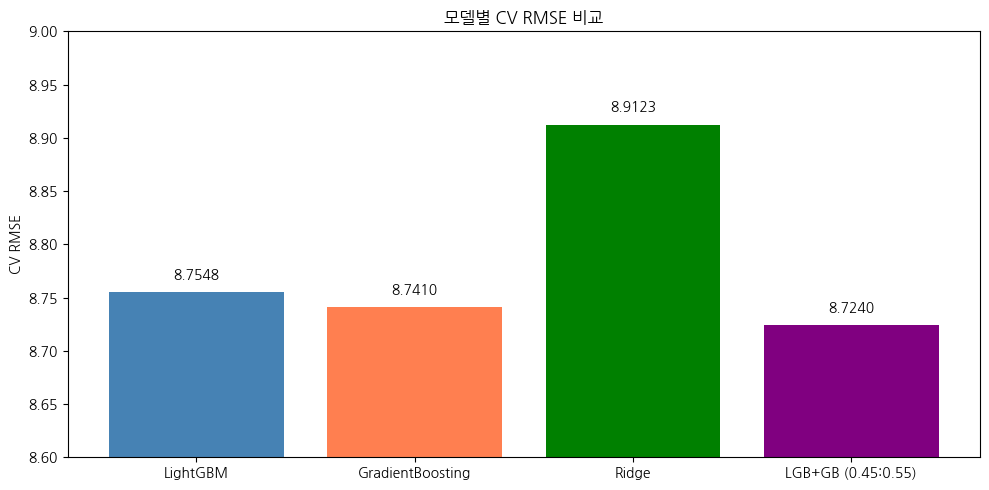

In [31]:
# 최종 모델 성능 비교 시각화
models = ['LightGBM', 'GradientBoosting', 'Ridge', 'LGB+GB (0.45:0.55)']
rmses = [
    np.sqrt(mean_squared_error(y_all, oof_reg_all)),
    np.sqrt(mean_squared_error(y_all, gb_oof)),
    ridge_rmse,
    best_rmse
]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(models, rmses, color=['steelblue', 'coral', 'green', 'purple'])
ax.set_ylabel('CV RMSE')
ax.set_title('모델별 CV RMSE 비교')
ax.set_ylim([8.6, 9.0])

for bar, rmse in zip(bars, rmses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{rmse:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [32]:
# 최종 테스트 예측 생성 (최적 앙상블)
w_lgb, w_gb = 0.45, 0.55
final_test_pred = test_reg_all * w_lgb + gb_test * w_gb

# clipping (0-100)
final_test_pred = np.clip(final_test_pred, 0, 100)

print(f"최종 예측 통계:")
print(f"  Min: {final_test_pred.min():.2f}")
print(f"  Max: {final_test_pred.max():.2f}")
print(f"  Mean: {final_test_pred.mean():.2f}")
print(f"  Std: {final_test_pred.std():.2f}")

최종 예측 통계:
  Min: 17.52
  Max: 100.00
  Mean: 62.53
  Std: 16.71


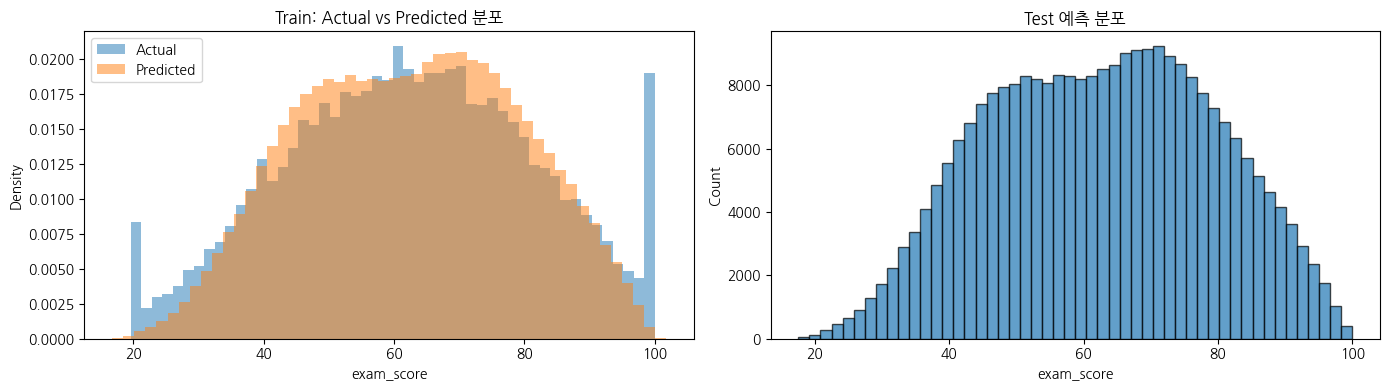

In [33]:
# 예측 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Train 실제값 vs 최종 OOF 예측
final_oof = oof_reg_all * w_lgb + gb_oof * w_gb
axes[0].hist(y_all, bins=50, alpha=0.5, label='Actual', density=True)
axes[0].hist(final_oof, bins=50, alpha=0.5, label='Predicted', density=True)
axes[0].set_xlabel('exam_score')
axes[0].set_ylabel('Density')
axes[0].set_title('Train: Actual vs Predicted 분포')
axes[0].legend()

# Test 예측 분포
axes[1].hist(final_test_pred, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('exam_score')
axes[1].set_ylabel('Count')
axes[1].set_title('Test 예측 분포')

plt.tight_layout()
plt.show()

In [34]:
# 제출 파일 생성
import os

submission['exam_score'] = final_test_pred

filename = f'submission_lgb_gb_ensemble_rmse{best_rmse:.4f}.csv'
filepath = os.path.join(r'E:\2026_1\캐글 공모전\영현\sbmission_result', filename)

submission.to_csv(filepath, index=False)

print(f"제출 파일 저장: {filename}")
print(f"\n제출 파일 미리보기:")
print(submission.head(10))

제출 파일 저장: submission_lgb_gb_ensemble_rmse8.7240.csv

제출 파일 미리보기:
       id  exam_score
0  630000   71.201366
1  630001   70.077470
2  630002   87.486810
3  630003   56.403965
4  630004   46.429476
5  630005   71.712659
6  630006   74.383498
7  630007   57.674109
8  630008   79.946691
9  630009   91.204602


## 8. 결과 요약 및 향후 개선 방향

### 진행 사항
1. 데이터 생성 로직 역추적 분석
   - exam_score는 선형 공식 기반 + 노이즈 + 0-100 clipping으로 생성된 것으로 추정
   - 핵심 변수: study_hours (계수 5.68), class_attendance (계수 0.31), sleep_hours (계수 1.33)
   
2. 100점 이진 분류 모델 시도
   - LightGBM 분류 AUC 0.966 달성
   - 하지만 분류-회귀 결합 전략이 단순 회귀보다 성능이 낮음
   
3. 앙상블 접근법
   - LightGBM + GradientBoosting (0.45:0.55) 블렌딩으로 최종 CV RMSE 8.7240

### 향후 개선 방향
1. CatBoost, XGBoost 등 더 다양한 모델 추가
2. Stacking 앙상블 시도
3. Pseudo-labeling 적용
4. 더 정교한 피처 엔지니어링
5. 저득점/고득점 구간별 별도 모델링